In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

#sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# special for 009265
#selected = selected[7:-1]

# showcase
# selected = [
#    '009266_hippoSIT_2023-05-04_19-47-15',
#    '009266_hippoSIT_2023-04-17_17-04-17',
#    '009266_hippoSIT_2023-05-23_09-18-05'
# ]
# selected = [
#     '009265_hippoSIT_2023-03-09_20-03-08',
#     '009265_hippoSIT_2023-03-05_11-52-17'
# ]

selected = [
    "57_SIT_2023-12-21_15-05-52",
    "57_SIT_2023-12-22_14-08-07",
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_16-38-05",
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-54-59",
]

selected

['57_SIT_2023-12-21_15-05-52',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-54-59']

In [11]:
ft = 'tSNE'
fp = 70
#ft = 'UMAP'
#fp = 0.5
speed_thresh = 0.04  # m/s
margin = 5
sigma = 0.3

## Plot BGR, TGT, SIL on Neural manifold

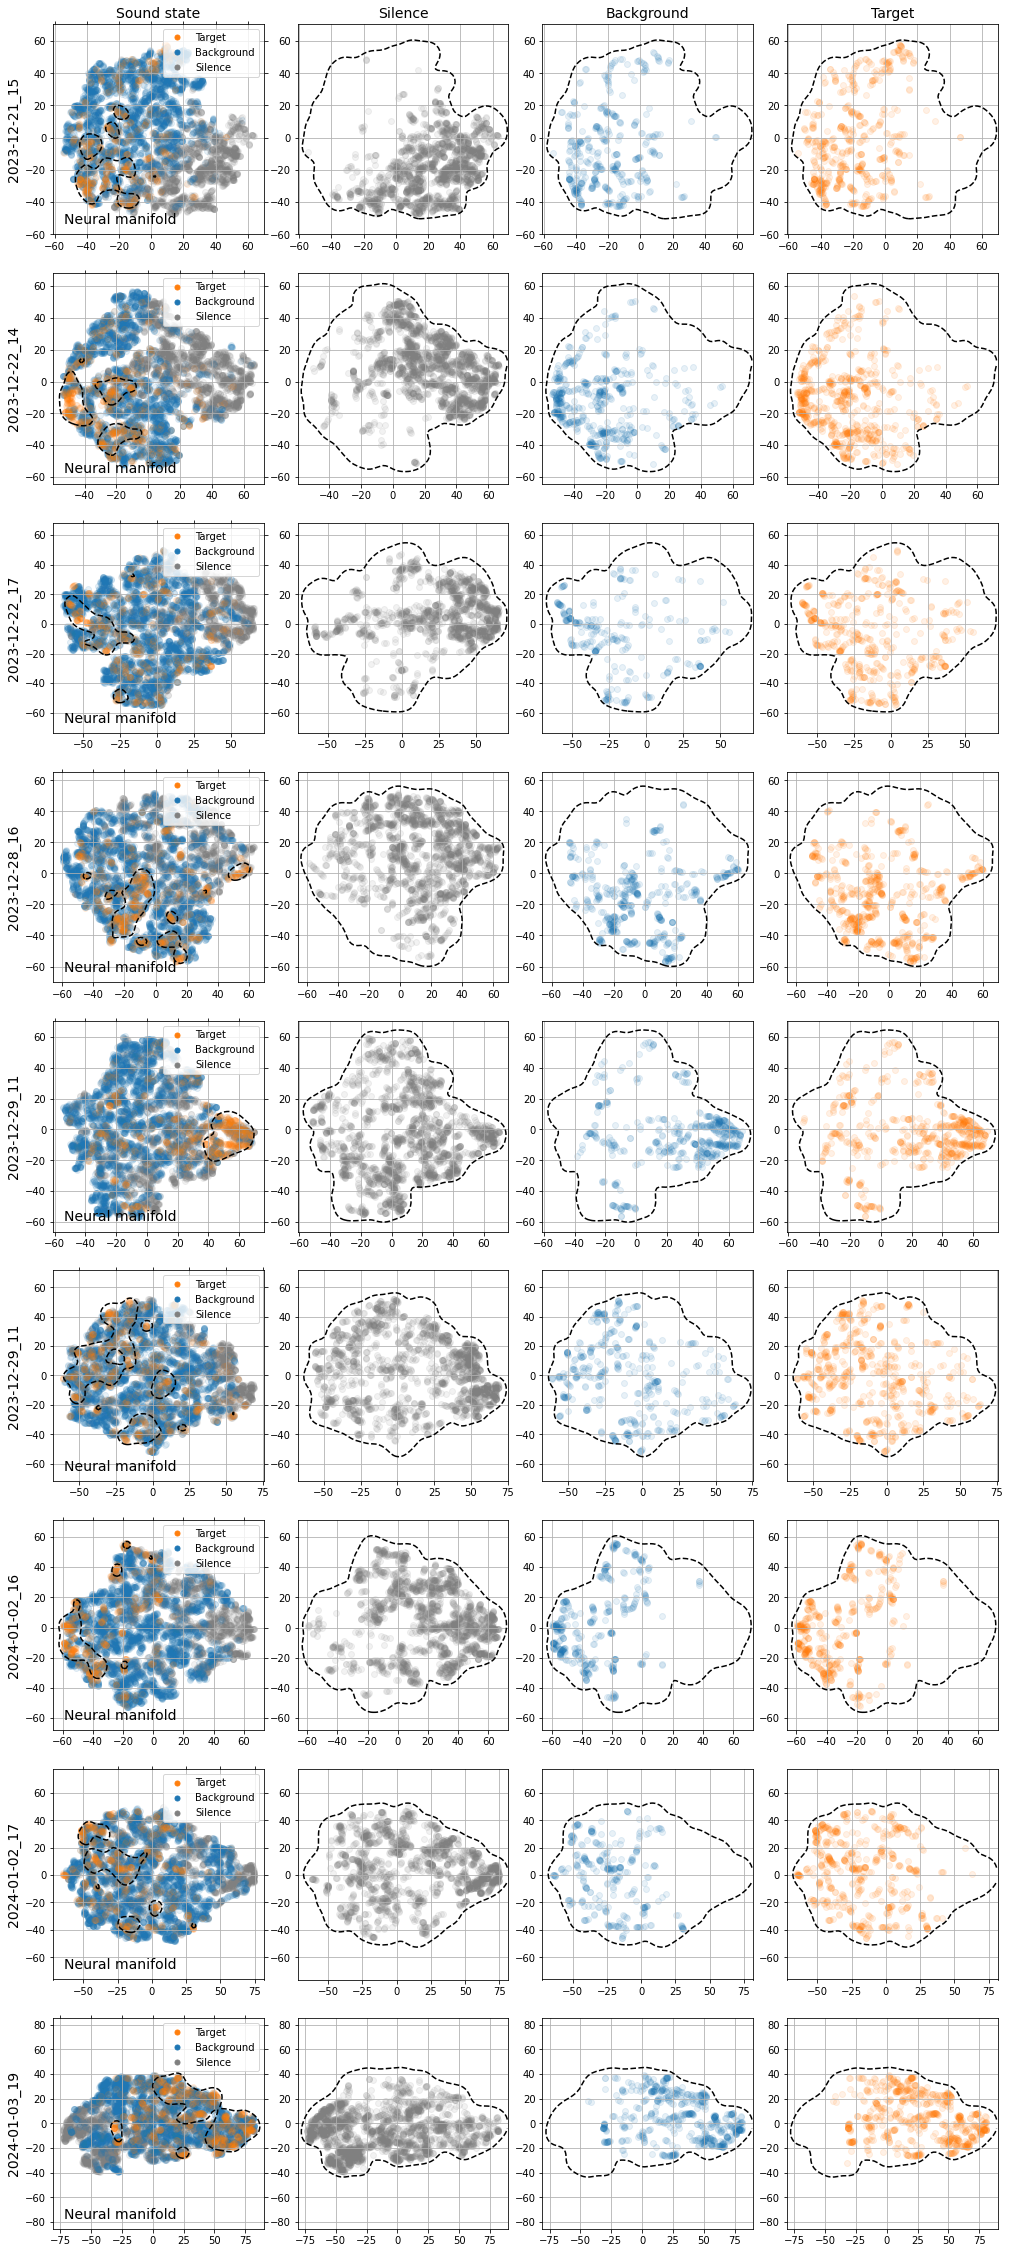

In [12]:
colors = ['grey', 'tab:blue', 'tab:orange']
titles = ['Sound state', 'Silence', 'Background', 'Target']
#cmaps  = ['Greens', 'Blues']
fig, axes = plt.subplots(len(selected), 4, figsize=(14, 3.5*len(selected)))

s_stats = {}
for j, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
        
    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial
    
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    # fit contours
    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    
    # whole manifold
    d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_fit = axes[j][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    # silence and TGT success
    d_map  = density_map(fit[idxs_sil_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    SIL_fit = axes[j][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    d_map  = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.35*d_map.max(), d_map.max(), 2)
    TGT_fit = axes[j][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    axes[j][0].clear()
    
    ax = axes[j][0]
    ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], alpha=0.1, color='grey', label='SIL')
    ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='tab:blue', label='BGR')
    ax.scatter(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1], alpha=0.1, color='tab:orange', label='TGT')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('equal')
    ax.set_ylabel(session[-19:-6], fontsize=14)
    ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Neural manifold', fontsize=14)
    ax.grid()
    legend_elements = [
        Line2D([0], [0], marker='.', linestyle='None', color='tab:orange', markersize=10, label='Target'),
        Line2D([0], [0], marker='.', linestyle='None', color='tab:blue', markersize=10, label='Background'),
        Line2D([0], [0], marker='.', linestyle='None', color='grey', markersize=10, label='Silence')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    #for path in SIL_fit.collections[0].get_paths():
    #    verts = path.vertices
    #    ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
    for path in TGT_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
    
    # separate plots
    idxs_state = [idxs_sil_ev, idxs_succ_ev, idxs_tgt_ev]
    for i, idxs in enumerate(idxs_state):
        ax = axes[j][i+1]
        for path in CS_fit.collections[0].get_paths():
            verts = path.vertices
            ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
        ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=0.1, color=colors[i])
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        ax.grid()

    #for ax in axes[j]:
    #    ax.set_xlabel('tSNE 1', fontsize=14)
    if j == 0:
        for k in range(4):
            axes[j][k].set_title(titles[k], fontsize=14)
        
    #legend_elements = [
    #    Line2D([0], [0], marker='.', linestyle='None', color='red', markersize=10, label='silence'),
    #    Line2D([0], [0], marker='.', linestyle='None', color='blue', markersize=10, label='background')
    #]

fig.tight_layout()

In [83]:
fig.savefig(os.path.join(report, 'showroom', 'nMAP_SIL_BGR_TGT_%s_sample.png' % animal), dpi=500)

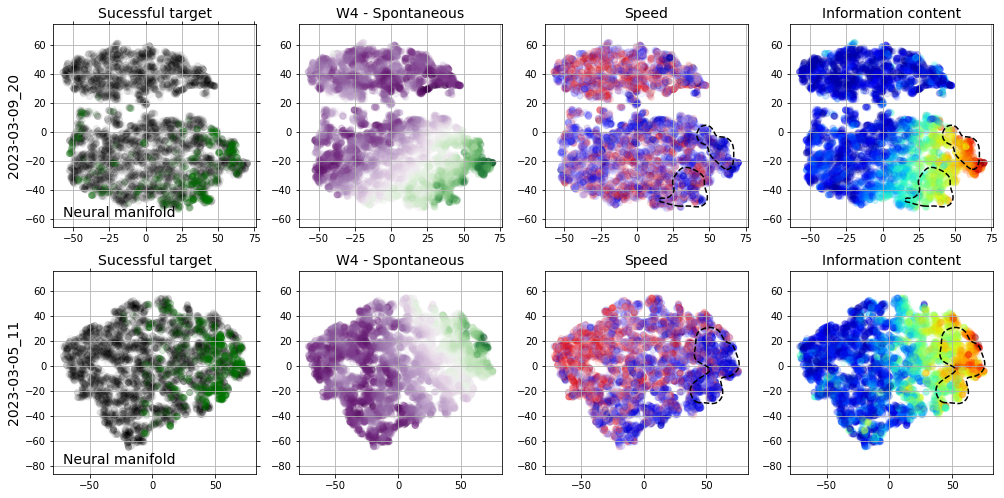

In [7]:
titles = ['Sucessful target', 'W4 - Spontaneous', 'Speed', 'Information content']
rows = len(selected)
fig, axes = plt.subplots(rows, 4, figsize=(14, rows*3.5))

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
#     with h5py.File(moseq_class_file, 'r') as f:
#         idxs_srm_tl = np.array(f['idxs_srm_tl'])
#         b_fit = np.array(f[ft][str(fp)])

    speed_ev = speed[events[:, 2].astype(np.int32)]
    #idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
    
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    extent = get_extent(fit, margin=5)
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]

    times_to_event = [15, 28, 73, 100]
    bins, unit_mx = unit_response_matrix(s_path, [1, 2], times_to_event=times_to_event)

    sig = unit_mx[1::len(times_to_event) + 1].mean(axis=1) * (250/13) # norm by window size
    noi = unit_mx[4::len(times_to_event) + 1].mean(axis=1) * (250/150) # norm by window size

    k_width = 30
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    sig_sm = np.convolve(sig, kernel, 'same') / kernel.sum()
    noi_sm = np.convolve(noi, kernel, 'same') / kernel.sum()

    snr = np.ones(len(sig_sm))
    #idxs_noi_non_zero = np.where(noi_sm != 0)[0]
    #snr[idxs_noi_non_zero] = ((np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm)[idxs_noi_non_zero]
    #snr[idxs_noi_non_zero] = (np.abs(sig_sm - noi_sm)/noi_sm)[idxs_noi_non_zero]
    snr = (np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm

    # pop response at phase
    w1 = activity_at_phase(s_path, phase=1, do_pca=True, k_width=30)
    w4 = activity_at_phase(s_path, phase=4, do_pca=True, k_width=30)
    
    # -----------
    
    # fit contours
    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    
    # whole fit
    d_map  = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_fit = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    # TGT only fit
    d_map  = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.35*d_map.max(), d_map.max(), 2)
    TGT_fit = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    axes[i][0].clear()
    
    # plotting - bE / bU states
    ax = axes[i][0]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.03, color='black', label='bU')
    ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.1, color='green')
    ax.set_ylabel(session[-19:-6], fontsize=14)
    ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Neural manifold', fontsize=14)
    #ax.legend(loc='lower left')

    # plotting - W4
    ax = axes[i][1]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='PRGn', c=w1)

    # plotting - W1
    #ax = axes[i][1]
    #ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='PRGn', c=w4)
    ax = axes[i][2]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=np.log(speed_ev))
    for path in TGT_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
    
    # plotting - SNR
    ax = axes[i][3]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='jet', c=np.log(snr))
    for path in TGT_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
        
    for j, ax in enumerate(axes[i]):
        ax.grid()
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        ax.set_title(titles[j], fontsize=14)
        #for path in CS_fit.collections[0].get_paths():
        #    verts = path.vertices
        #    ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
            
fig.tight_layout()

In [9]:
fig.savefig(os.path.join(report, 'showroom', 'nMAP_TGTsucc_W4_SPEED_SNR_%s_sample.png' % animal), dpi=300)

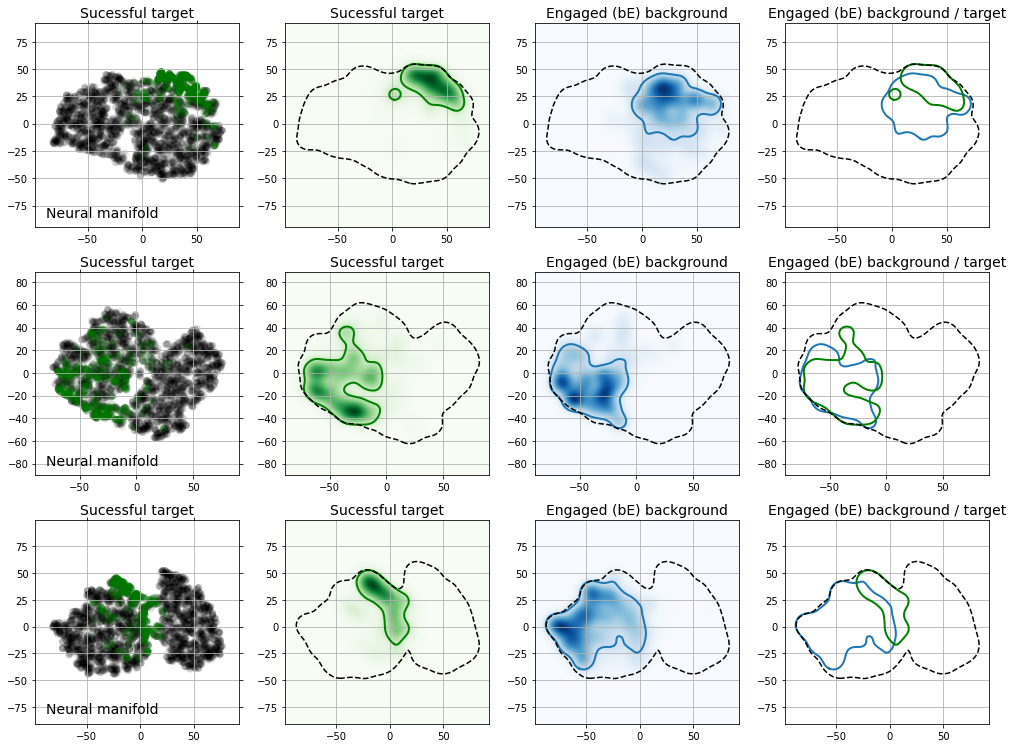

In [66]:
ft, fp = 'tSNE', 70
#ft, fp = 'UMAP', 0.5
margin = 10
speed_thresh = 10.04  # m/s
bin_count = 100
titles = ['Sucessful target', 'Sucessful target', 'Engaged (bE) background', 'Engaged (bE) background / target']
rows = len(selected)
fig, axes = plt.subplots(rows, 4, figsize=(14, rows*3.5))

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
#     with h5py.File(moseq_class_file, 'r') as f:
#         idxs_srm_tl = np.array(f['idxs_srm_tl'])
#         b_fit = np.array(f[ft][str(fp)])

    speed_ev = speed[events[:, 2].astype(np.int32)]
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    #idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
    
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    extent = get_extent(fit, margin=5)
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]

    idxs_AL_bgr_ev  = np.intersect1d(idxs_AL_ev, idxs_bgr_ev)
    idxs_AL_bgr_rest_ev = np.intersect1d(idxs_AL_bgr_ev, idxs_sta_ev)
    
#     times_to_event = [15, 28, 73, 100]
#     bins, unit_mx = unit_response_matrix(s_path, [1, 2], times_to_event=times_to_event)

#     sig = unit_mx[1::len(times_to_event) + 1].mean(axis=1) * (250/13) # norm by window size
#     noi = unit_mx[4::len(times_to_event) + 1].mean(axis=1) * (250/150) # norm by window size

#     k_width = 30
#     kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
#     sig_sm = np.convolve(sig, kernel, 'same') / kernel.sum()
#     noi_sm = np.convolve(noi, kernel, 'same') / kernel.sum()

#     snr = np.ones(len(sig_sm))
#     #idxs_noi_non_zero = np.where(noi_sm != 0)[0]
#     #snr[idxs_noi_non_zero] = ((np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm)[idxs_noi_non_zero]
#     #snr[idxs_noi_non_zero] = (np.abs(sig_sm - noi_sm)/noi_sm)[idxs_noi_non_zero]
#     snr = (np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm

#     # pop response at phase
#     w1 = activity_at_phase(s_path, phase=1, do_pca=True, k_width=30)
#     w4 = activity_at_phase(s_path, phase=4, do_pca=True, k_width=30)
    
    # -----------
    
    # fit contours
    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    
    # neural map fit density
    d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    NM_fit = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)

    # successful target fit density
    s_map  = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.23*s_map.max(), s_map.max(), 2)
    CS_fit = axes[i][0].contour(s_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    # engaged behavior fit density
    b_map  = density_map(fit[idxs_AL_bgr_rest_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.2*b_map.max(), b_map.max(), 2)
    bE_fit = axes[i][0].contour(b_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    axes[i][0].clear()
    
    # plotting - successful target
    ax = axes[i][0]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.03, color='black', label='bU')
    ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.1, color='green')
    #ax.set_ylabel(session[-19:-6], fontsize=14)
    ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Neural manifold', fontsize=14)
    #ax.legend(loc='lower left')

    # successful target - density map
    ax = axes[i][1]
    #s_map = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=bin_count)
    levels = np.linspace(0.3*s_map.max(), s_map.max(), 2)
    ax.imshow(s_map.T, cmap='Greens', origin='lower', extent=extent)
    for path in CS_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='green', lw=2)
        
    ax = axes[i][2]
    #s_map = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=bin_count)
    levels = np.linspace(0.3*b_map.max(), b_map.max(), 2)
    ax.imshow(b_map.T, cmap='Blues', origin='lower', extent=extent)
    for path in bE_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='tab:blue', lw=2)
        
    ax = axes[i][3]
    for path in bE_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='tab:blue', lw=2)
    for path in CS_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='green', lw=2)
    
    for j, ax in enumerate(axes[i]):
        ax.grid()
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        ax.set_title(titles[j], fontsize=14)
        if j > 0:
            for path in NM_fit.collections[0].get_paths():
                verts = path.vertices
                ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
            
fig.tight_layout()

In [67]:
fig.savefig(os.path.join(report, 'showroom', 'nMAP_TGTsucc_bE-BGR_%s_sample.png' % animal), dpi=500)